In [1]:
# !echo '{"username":"mygaps","key":"c865d568876db7d1a9457943a3ac99bc"}' > ~/.kaggle/kaggle.json
# !kaggle competitions download -c anime-recommendation-rucode

In [1]:
!pip install catboost

Defaulting to user installation because normal site-packages is not writeable


In [3]:
from google.colab import drive
drive.mount('/content/drive')
import os
try:
    os.chdir("./drive/My Drive/RuCode/RuCode3/Рекомендации Аниме")
except Exception as e:
    print(e)
#  проверяем наличие файлов
directory = os.listdir()
directory

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['anime.csv',
 'sample_submission.csv',
 'user_ratings.csv',
 'submissions',
 'sub10.csv',
 'Решения',
 'collaborative-filtering-on-anime-data.ipynb',
 'baseline_ranking_estim.ipynb',
 'sub12.csv',
 'sub13.csv',
 'sub14.csv',
 'sub15.csv',
 'sub16.csv',
 'baseline_1.51.ipynb',
 'sub17.csv',
 'sub18.csv',
 'sub19.csv',
 'sub21.csv',
 'sub22.csv',
 'sub24.csv',
 'sub23.csv',
 'baseline_1.33359.ipynb',
 'ranker.ipynb',
 'baseline_catboost.ipynb',
 'catboost_info',
 'sub25.csv']

In [20]:
import numpy as np

def LabelEncoder(df, names):
    values = {}
    for name in df[names]:
        series = list(set(df[name]))
        values[name] = dict([[i, j] for i, j in zip(series,
                                                    range(len(series)))])
    return values

def to_encode(frame, names, encoding):
    df = frame.copy()
    for name in df[names]:
        df[name] = df[name].apply(lambda x: encoding[name].get(x, np.nan))
    return df

# Подготовка данных

In [128]:
import pandas as pd
import numpy as np

anime = pd.read_csv("anime.csv").replace("Unknown", np.nan)
ratings = pd.read_csv("user_ratings.csv", dtype=np.int32)
ratings = ratings.loc[ratings["rating"] != 0]
sample = pd.read_csv("sample_submission.csv")

In [129]:
sample_new = [[int(i) for i in id.split()] for id, rat in sample.values]
sample_df = pd.DataFrame(sample_new, columns=["user_id", "Id"])

In [96]:
ratings.head(3)

,user_id,anime_id,rating,watching_status,watched_episodes
0,0,121,8,1,0
1,0,12815,10,1,3
2,0,3588,9,1,13


In [130]:
# делим данные
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(ratings.drop(["watching_status",
                                                 "watched_episodes"],
                                                axis=1),
                                   test_size=0.1,
                                   random_state=42)

In [25]:
X_train.head(3)

,user_id,anime_id,rating
6147150,32104,41168,5
12933307,66845,11981,10
11253106,58330,916,6


In [132]:
grouped_ratings = X_train[["user_id", "rating"]].groupby("user_id")\
                                                .agg(["median", "mean", #"std",
                                                      "var", "count", "skew"
                                                     ])

additionally_user = pd.DataFrame(grouped_ratings.reset_index().values,
                                 columns=["user_id", "rating_median", "rating_mean",
                                          "rating_var", "rating_skew",
                                          "num_watched"])

additionally_user.head(3)

,user_id,rating_median,rating_mean,rating_var,rating_skew,num_watched
0,0.0,9.0,9.000000,1.000000,3.0,0.000000
1,1.0,7.0,7.283465,1.331709,127.0,-0.826844
2,3.0,7.0,7.508197,1.657899,183.0,-0.502368


In [133]:
categorical = ["Type", "Producers", "Licensors",
               "Studios", "Based on", "Age limit",
               "Duration"]

numeric = ["Avg score", "Num episodes", "In list",
           "In favourites", "Watching", "Finished",
           "On hold", "Dropped", "Planning to watch",
           "Group members", 'Score-10', 'Score-9',
           'Score-8', 'Score-7', 'Score-6',
           'Score-5', 'Score-4', 'Score-3',
           'Score-2', 'Score-1'
          ]

In [134]:
encode = LabelEncoder(anime, categorical)
anime_encode = to_encode(anime, categorical, encode)

In [135]:
X_train_add = X_train.merge(additionally_user, how="left", on="user_id")\
                     .merge(anime_encode[categorical + numeric + ["Id"]],
                            how="left", left_on="anime_id", right_on="Id")\
                            .drop(["user_id", "Id", "anime_id"], axis=1)\
                            .drop_duplicates()

In [136]:
X_test_add = X_test.merge(additionally_user, how="left", on="user_id")\
                     .merge(anime_encode[categorical + numeric + ["Id"]],
                            how="left", left_on="anime_id", right_on="Id")\
                            .drop(["user_id", "Id", "anime_id"], axis=1)\
                            .drop_duplicates()

In [103]:
X_train_add.head(3)

,rating,rating_median,rating_mean,rating_var,num_watched,Type,Producers,Licensors,Studios,Based on,...,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
0,10,9.0,8.103448,6.493553,116.0,3,2969,10,390,4,...,66252.0,96956.0,84546.0,41611.0,14305.0,6216.0,2578.0,994.0,512.0,922.0
1,7,6.0,4.754690,13.107366,693.0,3,34,119,942,12,...,1668.0,2980.0,6203.0,7513.0,3338.0,1659.0,575.0,205.0,98.0,89.0
2,0,0.0,1.272981,8.243709,359.0,3,677,192,877,12,...,4490.0,8549.0,16921.0,17138.0,8117.0,4029.0,1650.0,701.0,324.0,219.0


In [137]:
from autogluon.tabular import TabularPredictor

In [141]:
pred = TabularPredictor(label="rating", problem_type="regression")

No path specified. Models will be saved in: "AutogluonModels/ag-20210411_120020/"


In [ ]:
pred.fit(X_train, presets="best_quality")

Presets specified: ['best_quality']
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20210411_120020/"
AutoGluon Version:  0.1.0
Train Data Rows:    9815011
Train Data Columns: 2
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    5614.91 MB
	Train Data (Original)  Memory Usage: 78.52 MB (1.4% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('int', []) : 2 | ['user_id', 'anime_id']
	Types of features in processed data (raw dtype, special dtypes):
	

[1000]	train_set's rmse: 1.68961	valid_set's rmse: 1.69035
[1000]	train_set's rmse: 1.689	valid_set's rmse: 1.6906
[1000]	train_set's rmse: 1.68982	valid_set's rmse: 1.68648
[1000]	train_set's rmse: 1.6916	valid_set's rmse: 1.69135
[1000]	train_set's rmse: 1.68878	valid_set's rmse: 1.68842
[1000]	train_set's rmse: 1.69048	valid_set's rmse: 1.69157
[1000]	train_set's rmse: 1.69085	valid_set's rmse: 1.69405
[1000]	train_set's rmse: 1.69102	valid_set's rmse: 1.6907
[1000]	train_set's rmse: 1.68803	valid_set's rmse: 1.68889
[1000]	train_set's rmse: 1.69039	valid_set's rmse: 1.69374


	-1.6905	 = Validation root_mean_squared_error score
	1439.45s	 = Training runtime
	49.98s	 = Validation runtime
Fitting model: LightGBMXT_BAG_L1 ...


[1000]	train_set's rmse: 1.71752	valid_set's rmse: 1.71783
[2000]	train_set's rmse: 1.71457	valid_set's rmse: 1.71493
[3000]	train_set's rmse: 1.71195	valid_set's rmse: 1.71237
[4000]	train_set's rmse: 1.70985	valid_set's rmse: 1.71028
[5000]	train_set's rmse: 1.7081	valid_set's rmse: 1.70856
[6000]	train_set's rmse: 1.70663	valid_set's rmse: 1.7071
[7000]	train_set's rmse: 1.70541	valid_set's rmse: 1.70589
[8000]	train_set's rmse: 1.70418	valid_set's rmse: 1.70468
[9000]	train_set's rmse: 1.70316	valid_set's rmse: 1.70368
[10000]	train_set's rmse: 1.70226	valid_set's rmse: 1.70279
[1000]	train_set's rmse: 1.71725	valid_set's rmse: 1.71844
[2000]	train_set's rmse: 1.71372	valid_set's rmse: 1.71496
[3000]	train_set's rmse: 1.71141	valid_set's rmse: 1.71269
[4000]	train_set's rmse: 1.70943	valid_set's rmse: 1.71074
[5000]	train_set's rmse: 1.70776	valid_set's rmse: 1.70911
[6000]	train_set's rmse: 1.70624	valid_set's rmse: 1.7076
[7000]	train_set's rmse: 1.70498	valid_set's rmse: 1.70634

In [104]:
X_train, y_train = X_train_add.drop(["rating"], axis=1), X_train_add["rating"]
X_test, y_test = X_test_add.drop(["rating"], axis=1), X_test_add["rating"]

In [125]:
from catboost import CatBoostClassifier

model = CatBoostClassifier(verbose=1,
                          iterations=1000,
                          random_state=56,
                          task_type="GPU",
                          eval_metric="Accuracy",
                          #loss_function="RMSE",
                          grow_policy="Depthwise",
                          use_best_model=True)

In [127]:
model.fit(X_train, y_train,
          eval_set=(X_test, y_test == 0))

KeyboardInterrupt: 

In [113]:
sorted(zip(model.feature_names_, model.feature_importances_),
       key=lambda x: x[1], reverse=True)[:10]

[('rating_mean', 45.498502149055554),
 ('Finished', 12.802071131342665),
 ('Planning to watch', 7.083836507697306),
 ('rating_var', 6.570353066638482),
 ('Score-9', 5.049236289141738),
 ('Score-10', 5.047875492582905),
 ('Avg score', 3.0888337886298105),
 ('num_watched', 2.707125390906939),
 ('Score-8', 2.6109826685686435),
 ('Num episodes', 1.697859316135777)]

In [114]:
test = sample_df.merge(additionally_user, how="left", on="user_id")\
                .merge(anime_encode[categorical + numeric + ["Id"]], how="left",
                       on="Id")

In [115]:
additionally_user

,user_id,rating_median,rating_mean,rating_var,num_watched
0,0.0,8.0,8.000000,0.000000,2.0
1,1.0,7.0,5.369942,11.478626,173.0
2,2.0,0.0,0.000000,0.000000,54.0
3,3.0,4.0,3.787535,14.804162,353.0
4,4.0,0.0,2.731092,13.045720,119.0
...,...,...,...,...,...
98526,98594.0,9.0,9.076923,0.910256,13.0
98527,98595.0,7.0,5.228261,16.887503,184.0
98528,98596.0,9.0,8.294118,4.662465,85.0
98529,98597.0,8.0,5.960000,13.002044,275.0


# Отправка решения

In [119]:
df_out = pd.DataFrame()
df_out["Id"] = test["user_id"].astype(str) + " " + test["Id"].astype(str)
df_out["rating"] = model.predict(test.drop(["user_id", "Id"], axis=1))
# df_out.loc[df_out["rating"] < 0, "rating"] = 7.5
# df_out.loc[df_out["rating"] > 10, "rating"] = 10
df_out.head(3)

,Id,rating
0,0 249,7.885230
1,0 4181,8.863600
2,0 813,8.430304


<AxesSubplot:>

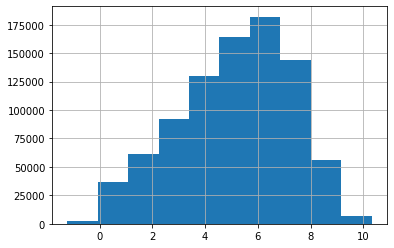

In [120]:
df_out["rating"].hist()

In [118]:
df_out.to_csv("sub38.csv", index=False)